In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'R_RLC.csv'
fr = pd.read_csv(FILE)

In [15]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VLC = np.array(fr['V_LC']) # V
ν = np.array(fr['Freq (Hz)']) # Hz 
ω = 2*np.pi*ν # rad/s
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦLC = np.array(fr['faseLC (deg)'], dtype=np.float64) * (np.pi / 180) # rad


sigma_Vin = np.array(fr['sigmaV_in']) # media 4 = sqrt(16)
sigma_VR = np.array(fr['sigmaV_R'])  # media 4 = sqrt(16)
sigma_VLC = np.array(fr['sigmaV_LC']) 

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad
sigma_ΦLC = np.array(fr['sigmaF_LC'], dtype=np.float64) * (np.pi/180.0) # rad

###### Calcolo funzioni di trasferimento ######

modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((sigma_VR/Vin)**2))

modHCL = VLC/Vin
sigma_modHCL = np.sqrt(((VLC/(Vin**2))*sigma_Vin)**2 + ((sigma_VLC/Vin)**2))
# print(modHR,sigma_modHR)

##### SISTEMAZIONE PHIR #######

# quando PHI_R è negativo, aggiungo 2pi

shift = lambda x: x + np.pi if x < 0 else x
shift = np.vectorize(shift)
ΦR = shift(ΦR)

- $|H_R(\omega)| = \frac{\omega CR}{\sqrt{(1-\omega^2LC)^2 + \omega^2C^2 (R+R_L)^2}}$

- $\angle H_R(\omega) = \frac{\pi}{2}-arctan(\frac{\omega C(R+R_L)}{1-\omega^2LC})$

In [16]:
def mod_HR_f(omega, C,L):
    numerator = omega * C * R
    denominator = np.sqrt((1 - (omega**2) * L * C)**2 + (omega**2) * (C**2) * (R + RL)**2)
    result = numerator / denominator
    return result

def arg_HR_f(omega, C,L):
    numerator = omega * C * (R + RL)
    denominator = 1 - (omega**2) * L * C
    angle = np.pi/2-np.arctan(numerator / denominator)
    return angle

In [17]:
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[10*10**-9,0.04])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[10*10**-9,0.04])
# print(fit_mod_HR)
# print(fit_arg_HR)

print("---------------------------MODULO R -------------------------")
print('chi2: ',fit_mod_HR.rchisquare)
print("---------------------------FASE R -------------------------")
print('chi2: ',fit_arg_HR.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------')
print('C = ',final_val(fit_mod_HR.bval[0],fit_mod_HR.sigma_bval[0],decimals=3,exp=-10,udm='F'))
print('L = ',final_val(fit_mod_HR.bval[1],fit_mod_HR.sigma_bval[1],decimals=3,exp=-3,udm='Hr'))

print('------------------------- VALORI RICAVATI DAL ARG HR -----------------------------')
print('C = ',final_val(fit_arg_HR.bval[0],fit_arg_HR.sigma_bval[0],decimals=3,exp=-10,udm='F'))
print('L = ',final_val(fit_arg_HR.bval[1],fit_arg_HR.sigma_bval[1],decimals=3,exp=-3,udm='Hr'))

---------------------------MODULO R -------------------------
chi2:  0.51
---------------------------FASE R -------------------------
chi2:  1.2
------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------
C =  (97.0 ± 2.936)e-10 F
L =  (48.723 ± 1.496)e-3 Hr
------------------------- VALORI RICAVATI DAL ARG HR -----------------------------
C =  (94.678 ± 5.204)e-10 F
L =  (53.444 ± 2.956)e-3 Hr


In [18]:
# x = np.logspace(2.5, 6.3, 1000)
# y = mod_HR_f(x, *fit_mod_HR.bval)

# plt.plot(x, y, label='Fit',color='yellowgreen')
# plt.errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='.',color='darkolivegreen')
# plt.xlabel('$\omega$')
# plt.ylabel('$|H_R(\omega)|$')
# plt.xscale('log')
# plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2 = $' + str(fit_mod_HR.rchisquare))
# plt.show()

In [19]:
# x = np.logspace(2.5, 6.3, 1000)
# y = arg_HR_f(x,10*10**-9,0.04)
# y = arg_HR_f(x, *fit_arg_HR.bval)

# plt.plot(x, y, label='Fit',color='yellowgreen')
# plt.errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.',color='darkolivegreen')
# plt.xlabel('$\omega$')
# plt.ylabel('$|H_R(\omega)|$')
# plt.xscale('log')
# plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2 = $' + str(fit_arg_HR.rchisquare))
# plt.show()

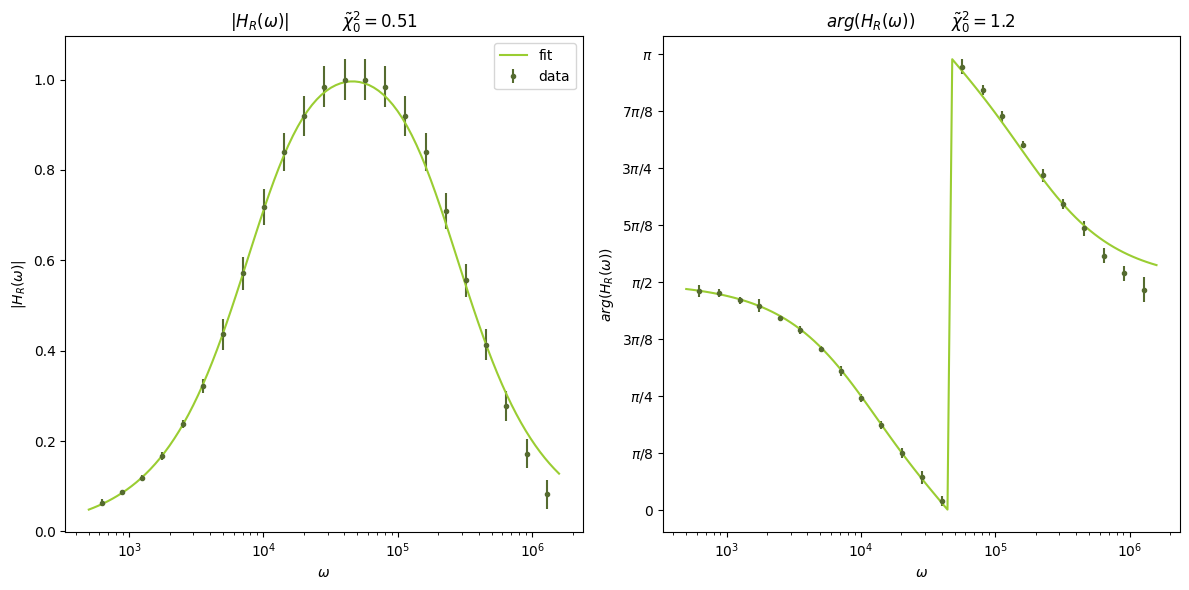

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Modulo HR
x = np.logspace(2.7, 6.2, 100)
y = mod_HR_f(x, *fit_mod_HR.bval)
axs[0].set_title('$|H_R(\omega)|$  \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
axs[0].errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='.', label='data', color='darkolivegreen')
axs[0].plot(x, y, label='fit', color='yellowgreen')
axs[0].set_xscale('log')
axs[0].set_ylabel('$|H_R(\omega)|$')
axs[0].set_xlabel('$\omega$')
axs[0].legend()

# Plot 2: Argomento HR
x = np.logspace(2.7, 6.2, 100)
y = arg_HR_f(x, *fit_arg_HR.bval)
axs[1].set_title('$arg(H_R(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HR.rchisquare))
axs[1].errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.', color='darkolivegreen', label='data')
axs[1].plot(x, y, color='yellowgreen', label='fit')
axs[1].set_xscale('log')
axs[1].set_ylabel('$arg(H_R(\omega))$')
axs[1].set_xlabel('$\omega$')

axs[1].set_yticks([np.pi/2,3*np.pi/8,np.pi/4,np.pi/8,0,5*np.pi/8,3*np.pi/4,7*np.pi/8,np.pi])
axs[1].set_yticklabels(['$\pi/2$','$3\pi/8$','$\pi/4$','$\pi/8$','0','$5\pi/8$','$3\pi/4$','$7\pi/8$','$\pi$'])


plt.tight_layout()
plt.show()


### $H_{CL}(\omega) = \frac{1 + \omega CR_Lj - \omega^2LC}{(R + R_L)\omega Cj + 1 - \omega^2 LC}$
- $|H_{CL}(\omega)| = \frac{\sqrt{(1-\omega^2 LC)^2 + \omega^2C^2 R_L^2}}{\sqrt{(1-\omega^2LC)^2 + \omega^2C^2 (R+R_L)^2}}$
- $\angle H_{CL}(\omega) = arctan(\frac{\omega CR_L}{1-\omega^2LC}) - arctan(\frac{\omega C(R+R_L)}{1-\omega^2LC})$

In [20]:
def mod_HCL_f(omega, C, L):
    d = (1 - omega**2 * L * C)**2 + omega**2 * C**2 * RL**2
    numerator = np.sqrt(d)
    denominator = np.sqrt((1 - omega**2 * L * C)**2 + omega**2 * C**2 * (R + RL)**2)
    return numerator / denominator

def arg_HCL_f(omega, C, L):
    term1 = np.arctan(omega * C * RL / (1 - omega**2 * L * C))
    term2 = np.arctan(omega * C * (R + RL) / (1 - omega**2 * L * C))
    return term1 - term2

In [24]:
fit_mod_HCL = Interpolazione(ω,modHCL,mod_HCL_f,sigma_modHCL,p0=[10*10**-9,0.04])
fit_arg_HCL = Interpolazione(ω,ΦLC,arg_HCL_f,sigma_ΦLC,p0=[10*10**-9,0.04])

print("---------------------------MODULO R -------------------------")
print('chi2: ',fit_mod_HCL.rchisquare)

print("---------------------------FASE R -------------------------")
print('chi2: ',fit_arg_HCL.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------')
print('C = ',final_val(fit_mod_HCL.bval[0],fit_mod_HCL.sigma_bval[0],decimals=3,exp=-10,udm='F'))
print('L = ',final_val(fit_mod_HCL.bval[1],fit_mod_HCL.sigma_bval[1],decimals=3,exp=-3,udm='Hr'))

print('------------------------- VALORI RICAVATI DAL ARG HR -----------------------------')
print('C = ',final_val(fit_arg_HCL.bval[0],fit_arg_HCL.sigma_bval[0],decimals=3,exp=-10,udm='F'))
print('L = ',final_val(fit_arg_HCL.bval[1],fit_arg_HCL.sigma_bval[1],decimals=3,exp=-3,udm='Hr'))

---------------------------MODULO R -------------------------
chi2:  0.1
---------------------------FASE R -------------------------
chi2:  1.85
------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------
C =  (94.345 ± 1.545)e-10 F
L =  (49.971 ± 0.82)e-3 Hr
------------------------- VALORI RICAVATI DAL ARG HR -----------------------------
C =  (90.629 ± 3.489)e-10 F
L =  (49.277 ± 1.912)e-3 Hr


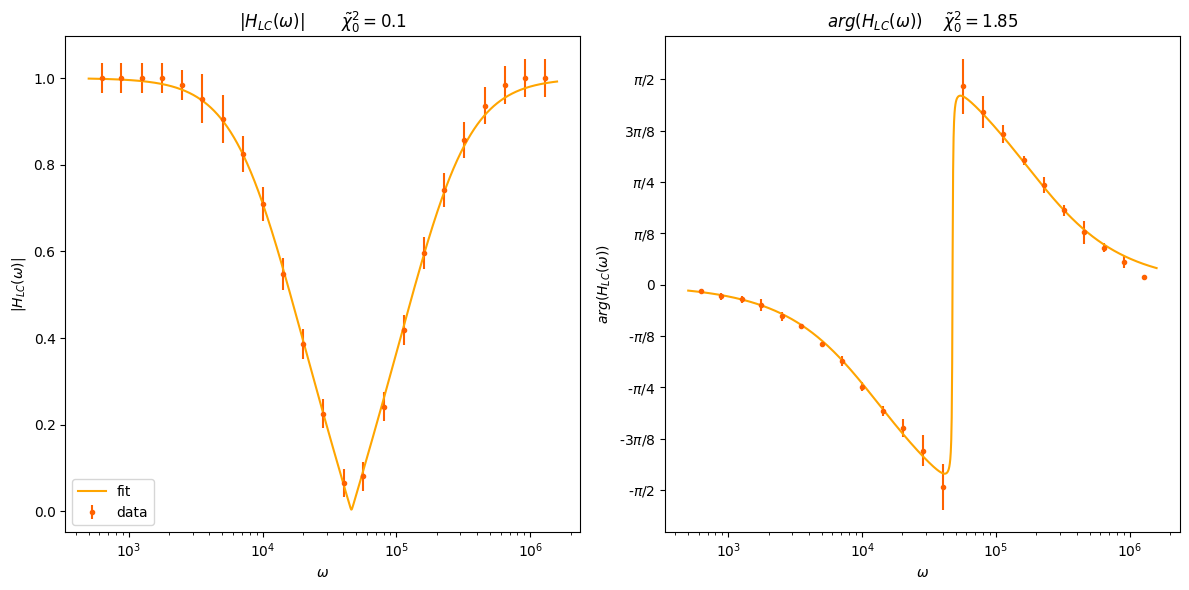

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Modulo HR
x = np.logspace(2.7, 6.2, 1000)
y = mod_HCL_f(x, *fit_mod_HCL.bval)
axs[0].set_title('$|H_{LC}(\omega)|$  \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HCL.rchisquare))
axs[0].errorbar(ω, modHCL, yerr=fit_mod_HCL.sigmaY, fmt='.', label='data', color='#ff6200')
axs[0].plot(x, y, label='fit', color='orange')
axs[0].set_xscale('log')
axs[0].set_ylabel('$|H_{LC}(\omega)|$')
axs[0].set_xlabel('$\omega$')
axs[0].legend()

# Plot 2: Argomento HR
x = np.logspace(2.7, 6.2, 1000)
y = arg_HCL_f(x, *fit_arg_HCL.bval)
axs[1].set_title('$arg(H_{LC}(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HCL.rchisquare))
axs[1].errorbar(ω, ΦLC, yerr=fit_arg_HCL.sigmaY, fmt='.', color='#ff6200', label='data')
axs[1].plot(x, y, color='orange', label='fit')
axs[1].set_xscale('log')
axs[1].set_ylabel('$arg(H_{LC}(\omega))$')
axs[1].set_xlabel('$\omega$')

axs[1].set_yticks([np.pi/2,3*np.pi/8,np.pi/4,np.pi/8,0,-np.pi/2,-3*np.pi/8,-np.pi/4,-np.pi/8])
axs[1].set_yticklabels(['$\pi/2$','$3\pi/8$','$\pi/4$','$\pi/8$','0','-$\pi/2$','-$3\pi/8$','-$\pi/4$','-$\pi/8$'])


plt.tight_layout()
plt.show()
